# Best video games from 1952 to 2029

### Auteurs : Ayman Akram & Rafael Teixeira

### Prof. Benoit Le Callennec

## Table of contents

- [Introduction](#introduction)
- [Data import and cleaning](#data-important-and-cleaning)
- [Data analysis](#data-analysis)
  - [Number of game per genre](#number-of-games-per-genre)
  - [Most played games](#most-played-games)
  - [Success per genre over the years](#success-per-genre-over-the-years)

## Introduction

Ce projet a pour but d'analyser statistiquement une base de données de jeux vidéo, en répondant à des questions  sur leurs caractéristiques, leur popularité et leur évolution dans le temps. sur un large ensemble. Puis d’en extraire des informations clés sur leurs genres, leur popularité, et leur évolution temporelle ???.

## Data import and cleaning
Import the data from kaggle [(link to data)](https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games/data?select=backloggd_games.csv).

If an error succeeds during data download, a fallback file is used. This file contains a previous version of the data and so, it may not be up to date.


### Load data and store it in pandas DataFrame

In [22]:
# Load and read data
import os
import pandas as pd
import kagglehub

file_path = ""
FILE_NAME = "backloggd_games.csv"
FALLBACK_PATH = "Datasets/"

try:
    # Download last version of dataset from kaggle
    path = kagglehub.dataset_download("matheusfonsecachaves/popular-video-games")
    print("Last version of file successfully loaded from kaggle.")
    file_path = path + "\\" + FILE_NAME

except:
    # If an exception is raised when downloading last version of dataset, the locally saved version is used. It may no be up to date
    print("Last version could not be successfully loaded from kaggle.\nThe locally saved dataset will be used but it may not be up to date.")
    file_path = FALLBACK_PATH + FILE_NAME

print("Path to dataset file:", file_path)

if os.path.exists(file_path):
    df = pd.read_csv(file_path)

else:
    print("The file does not exist. Check the path or place the file in the correct location.")

Last version of file successfully loaded from kaggle.
Path to dataset file: C:\Users\teixe\.cache\kagglehub\datasets\matheusfonsecachaves\popular-video-games\versions\1\backloggd_games.csv


### Data basic verifications

In [23]:
# Data basic verification : shape of dataFrame, columns informations and head
print("DataFrame shape : " + str(df.shape)) # row and columns
print("DataFrame info :")
df.info()
print("DataFrame head :")
print(df.head(6)) # Preview

DataFrame shape : (60000, 14)
DataFrame info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    60000 non-null  int64  
 1   Title         60000 non-null  object 
 2   Release_Date  60000 non-null  object 
 3   Developers    60000 non-null  object 
 4   Summary       55046 non-null  object 
 5   Platforms     60000 non-null  object 
 6   Genres        60000 non-null  object 
 7   Rating        25405 non-null  float64
 8   Plays         60000 non-null  object 
 9   Playing       60000 non-null  object 
 10  Backlogs      60000 non-null  object 
 11  Wishlist      60000 non-null  object 
 12  Lists         60000 non-null  object 
 13  Reviews       60000 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 6.4+ MB
DataFrame head :
   Unnamed: 0                                    Title  Release_Date  \
0   

### Null data and duplicates analysis

In [24]:
# Null verification
df.isnull().sum()

Unnamed: 0          0
Title               0
Release_Date        0
Developers          0
Summary          4954
Platforms           0
Genres              0
Rating          34595
Plays               0
Playing             0
Backlogs            0
Wishlist            0
Lists               0
Reviews             0
dtype: int64

Null data analysis shows that 34595 entries have a null value on Rating column.

If those entries are deleted, half of the data would be lost.

Rating column is not used on some analysis. Those entries will only be dropped when Rating is column is needed. All data is kept for the other analysis.

In [25]:
df.duplicated().sum()

np.int64(0)

The is no duplicate entry in the dataset.

### Transform date column values to numpy date

The Release_Date column contains dates with the following format.

For example 2 February 2023 will be Feb 02, 2023.

To work with those dates, they must be converted to a more convenient format such as numpy date.

When analysing the data of this column, some undefined dates can be found. Their value is 'TBD' and we choose to turn it to Nan so it is easier to remove when needed.

The column "Release_Date" values are replaced by their equivalent numpy date value or by numpy.nan if they do not match the defined date pattern.


In [26]:
import re
import numpy as np

## Analyse type of data :
DATE_REGEX = re.compile(r'[A-Z]{3} \d\d, \d{4}', re.I)
MONTH_REGEX = re.compile(r'[A-Z]{3}', re.I)
DAY_REGEX = re.compile(r'\d{2}(?=,)')
YEAR_REGEX = re.compile(r'(\d{4}$)')

MONTH_DICT = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}

def mapMonth(dateStr):
    global DATE_REGEX
    matches = re.match(DATE_REGEX, dateStr)
    if matches:
        return convertToNumpyDate(matches[0])
    else:
        return np.nan

def convertToNumpyDate(dateStr):
    global MONTH_REGEX, DAY_REGEX, YEAR_REGEX, MONTH_DICT
    # Find month :
    monthStr = re.search(MONTH_REGEX, dateStr)[0].lower()
    month = MONTH_DICT[monthStr]
    day = int(re.search(DAY_REGEX, dateStr)[0])
    year = int(re.search(YEAR_REGEX, dateStr)[0])
    return np.datetime64(f"{year}-{month:02d}-{day:02d}")


df['Release_date_converted'] = df['Release_Date'].map(mapMonth)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              60000 non-null  int64         
 1   Title                   60000 non-null  object        
 2   Release_Date            60000 non-null  object        
 3   Developers              60000 non-null  object        
 4   Summary                 55046 non-null  object        
 5   Platforms               60000 non-null  object        
 6   Genres                  60000 non-null  object        
 7   Rating                  25405 non-null  float64       
 8   Plays                   60000 non-null  object        
 9   Playing                 60000 non-null  object        
 10  Backlogs                60000 non-null  object        
 11  Wishlist                60000 non-null  object        
 12  Lists                   60000 non-null  object

### Transform Plays from string to number
The data in 'Plays' column is at string format of type 2K, 2M, etc.

We convert those values to number, removing the suffix K or M and multiplying by the right multiplier (1'000 or 1'000'000).

In [27]:
# Convert K and M abbreviations to integers
def parse_play_count(x):
    x = str(x).replace(',', '').strip().upper()
    if x.endswith('K'):
        return int(float(x[:-1]) * 1_000)
    elif x.endswith('M'):
        return int(float(x[:-1]) * 1_000_000)
    elif x.isdigit():
        return int(x)
    else:
        return None  # to invalid values

df['Plays'] = df['Plays'].apply(parse_play_count)

### Drop unused colums

In [28]:
try :
    df.drop(["Developers", "Summary", "Platforms", "Playing", "Backlogs", "Wishlist", "Lists"], axis=1, inplace=True)
except Exception as e:
    print("An error was raised. It could be because columns have already been erased.")
    print(e)
df.shape

(60000, 8)

## Data analysis


### Number of games per genre
We use "Genres" columns.

In [29]:
# Remove missing values, convert to string, and clean characters like [], '
all_genres = df['Genres'].dropna().astype(str).str.replace(r'[\[\]\']', '', regex=True)

# Split genres by comma, explode into rows, and strip whitespace
all_genres = all_genres.str.split(',').explode().str.strip()
print(all_genres)

# We remove empty genres 
all_genres = all_genres[all_genres != ""]


0        Adventure
0              RPG
1        Adventure
1           Puzzle
2        Adventure
           ...    
59996     Tactical
59997             
59998          RPG
59999          RPG
59999     Tactical
Name: Genres, Length: 115198, dtype: object


In [30]:
# Counting occurrences
genre_counts = all_genres.value_counts()
print("Number of games by genre :\n", genre_counts.head(10))

Number of games by genre :
 Genres
Adventure    19368
Indie        16816
RPG           9234
Simulator     8050
Strategy      7766
Shooter       7258
Puzzle        6935
Platform      6126
Arcade        5603
Sport         3912
Name: count, dtype: int64


In [31]:
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interactive_output, VBox
from IPython.display import display 

# Widget to select how many genres to display
top_n_slider = IntSlider(value=10, min=1, max=23, step=1, description='Top N:')

# Graphical
def plot_top_n(n):
    plt.figure(figsize=(12, 6))
    genre_counts.head(n).plot(kind='bar')
    plt.title(f"Top {n} Game Genres")
    plt.xlabel("Genre")
    plt.ylabel("Number of games")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Binding and display
display(VBox([top_n_slider, interactive_output(plot_top_n, {'n': top_n_slider})]))

### Most played games
We use "Plays" and "Title" columns.

In [32]:
# Sort games by number of plays
top_played = df[['Title', 'Plays']].sort_values(by='Plays', ascending=False)
top_played.dropna(inplace=True)
print("\nTop 10 most played games:")
print(top_played.head(10))


Top 10 most played games:
                                      Title    Plays
5                                 Minecraft  38000.0
1   The Legend of Zelda: Breath of the Wild  35000.0
23                       Grand Theft Auto V  35000.0
13                                 Portal 2  34000.0
22                                   Portal  32000.0
4                                 Undertale  32000.0
21                      Super Mario Odyssey  29000.0
35               Super Smash Bros. Ultimate  29000.0
11                                 Among Us  29000.0
56              The Elder Scrolls V: Skyrim  26000.0


<Figure size 1200x1000 with 0 Axes>

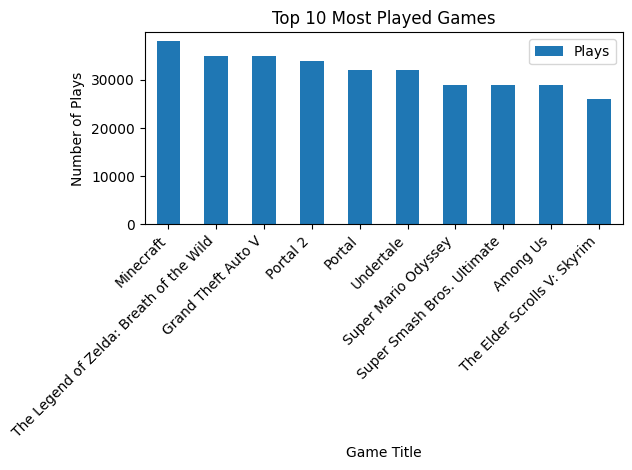

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_nbr_of_plays_top_n_(n):
    global top_played
    plt.figure(figsize=(12, 10))
    top_played.head(n).plot(x="Title",y="Plays",kind="bar")
    # plt.bar(top_played['Title'], top_played['Plays'])
    plt.title("Top 10 Most Played Games")
    plt.xlabel("Game Title")
    plt.ylabel("Number of Plays")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_nbr_of_plays_top_n_(10)


### Success per genre over the years

To determine the succes of a game, we consider the number of plays it has and the rate.

To calculate a success score, the following formula is used :

success_score = rating^4 * plays^0.5

Using a power 4 on "rating", increases "rating" weight on success score.

On the contrary, a power of 0.5 on "plays", decreases "plays" weight on success score.



In [ ]:
import ipywidgets as widgets

# Sort by Release date
df.sort_values("Release_date_converted", inplace=True)
# Calculate Success_score for each game
df['Weighted_rating'] = df["Rating"]**4
df['Weighted_number_plays'] = df["Plays"]**0.5
df['Success_score'] = df['Weighted_rating'] * df['Weighted_number_plays']

# Get a copy of the dataframe, drop Nan values and replace
success_score_and_genre_per_date = df[['Release_date_converted','Genres', 'Success_score']].dropna()

genres = df['Genres'].str.replace(r'[\[\]\']', '', regex=True).str.split(',').explode().str.strip().drop_duplicates().sort_values()

genre_dropdown = widgets.Dropdown(options=genres, description="Genre:")

def getSuccessScoresByGenre(dataframe, genre):
    # filter given dataframe keeping only lines where column Genres contains wanted genre
    filtered = dataframe[dataframe["Genres"].map(lambda x: genre in x)]
    return filtered


def plotChart(genre):
    global success_score_and_genre_per_date
    filtered = getSuccessScoresByGenre(success_score_and_genre_per_date, genre)
    success_score_per_year = filtered['Success_score'].groupby(filtered['Release_date_converted'].dt.to_period("Y")).sum()
    # Convert years to int and plot
    success_score_per_year.index = success_score_per_year.index.astype("str").astype("int64")
    plt.plot(success_score_per_year.index, success_score_per_year.values,)
    if not genre:
        genre = "all genre"
    plt.title("Success of " + genre + " games over the years")
    plt.xlabel("Release year")
    plt.ylabel("Success score")
    plt.tight_layout()

widgets.interact(plotChart, genre=genre_dropdown)

interactive(children=(Dropdown(description='Genre:', options=('', 'Adventure', 'Arcade', 'Brawler', 'Card & Bo…

<function __main__.plotChart(genre)>

The above analysis shows the success score drops after 2020.
This drop can have multiple causes but most likely is that recent games have less "plays" than older games.

The analyzed dataset most recent games were released in 2023.

We can quickly analyze when the 'Plays' value seems to start dropping (see below).

We can see that it starts dropping in 2017. We can make the hypothesis that data > 2017 is not complete or is too recent game to be compared with older games.

<bound method Series.info of Release_date_converted
1952        32.0
1954         3.0
1971       475.0
1972      2849.0
1973       109.0
1974       103.0
1975        10.0
1976       421.0
1977       743.0
1978      2537.0
1979      1832.0
1980      7452.0
1981      9346.0
1982     10850.0
1983      8062.0
1984     16849.0
1985     33266.0
1986     37600.0
1987     37933.0
1988     42358.0
1989     47251.0
1990     66665.0
1991     84322.0
1992     79591.0
1993    104070.0
1994    128124.0
1995     92983.0
1996    145677.0
1997    141563.0
1998    179881.0
1999    196561.0
2000    155391.0
2001    257709.0
2002    256496.0
2003    255654.0
2004    387148.0
2005    357743.0
2006    364924.0
2007    488155.0
2008    440060.0
2009    483501.0
2010    502850.0
2011    571811.0
2012    595573.0
2013    640682.0
2014    594601.0
2015    659150.0
2016    701383.0
2017    734765.0
2018    646166.0
2019    564404.0
2020    483523.0
2021    375966.0
2022    261618.0
2023     60491.0
2024       14

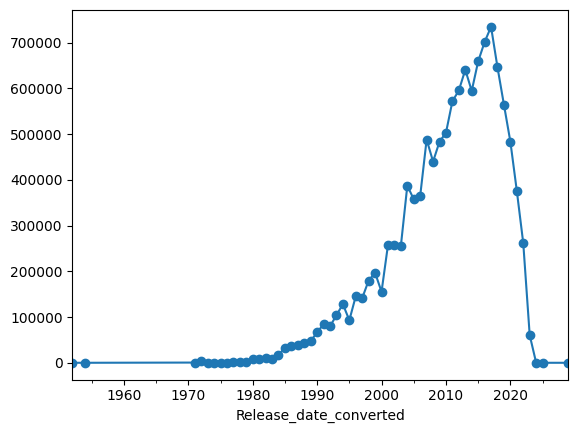

In [35]:
plays_per_year = df['Plays'].groupby(df['Release_date_converted'].dt.to_period("Y")).sum()
plays_per_year.plot(kind="line", marker= 'o')
plays_per_year.info